In [1]:
# !conda list
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import torch
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(0))
print(torch.cuda.set_device(0))

1
0
GeForce GTX 1070
None


In [2]:
from fastai.vision import *
from fastai.utils.mem import *

## I. Preparation

### Install neccessary

In [1]:
!pip install kaggle --upgrade

Requirement already up-to-date: kaggle in /home/minhnc-lab/PROGRAMS/anaconda3/envs/fastaiv1/lib/python3.6/site-packages (1.5.3)


In [5]:
! mkdir -p ~/.kaggle/
! mv kaggle.json ~/.kaggle/

# For Windows, uncomment these two commands
! mkdir %userprofile%\.kaggle
! move kaggle.json %userprofile%\.kaggle

mkdir: cannot create directory ‘%userprofile%.kaggle’: File exists
/bin/sh: 1: move: not found


In [3]:
path = Config.data_path()/'planet'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/home/minhnc-lab/.fastai/data/planet')

In [7]:
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p {path}  
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p {path}  
! unzip -q -n {path}/train_v2.csv.zip -d {path}

100%|███████████████████████████████████████▉| 599M/600M [01:07<00:00, 6.04MB/s]
100%|████████████████████████████████████████| 600M/600M [01:07<00:00, 9.37MB/s]
  0%|                                                | 0.00/159k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 159k/159k [00:00<00:00, 11.4MB/s]


In [9]:
! conda install -y -c haasad eidl7zip

Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /home/minhnc-lab/PROGRAMS/anaconda3/envs/fastaiv1:

The following NEW packages will be INSTALLED:

    eidl7zip: 1.0.0-1 haasad

eidl7zip-1.0.0 100% |################################| Time: 0:00:01 531.74 kB/s


In [10]:
! 7za -bd -y -so x {path}/train-jpg.tar.7z | tar xf - -C {path.as_posix()}

### Explore data

In [4]:
df = pd.read_csv(path/'train_v2.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [5]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [6]:
np.random.seed(42)
src = (ImageList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
      .random_split_by_pct(0.2)
      .label_from_df(label_delim=' '))

/home/minhnc-lab/PROGRAMS/anaconda3/envs/fastaiv1/lib/python3.6/site-packages/fastai/data_block.py:198: UserWarning: `random_split_by_pct` is deprecated, please use `split_by_rand_pct`.
  warn("`random_split_by_pct` is deprecated, please use `split_by_rand_pct`.")


In [7]:
data = (src.transform(tfms, size=256)
       .databunch().normalize(imagenet_stats))

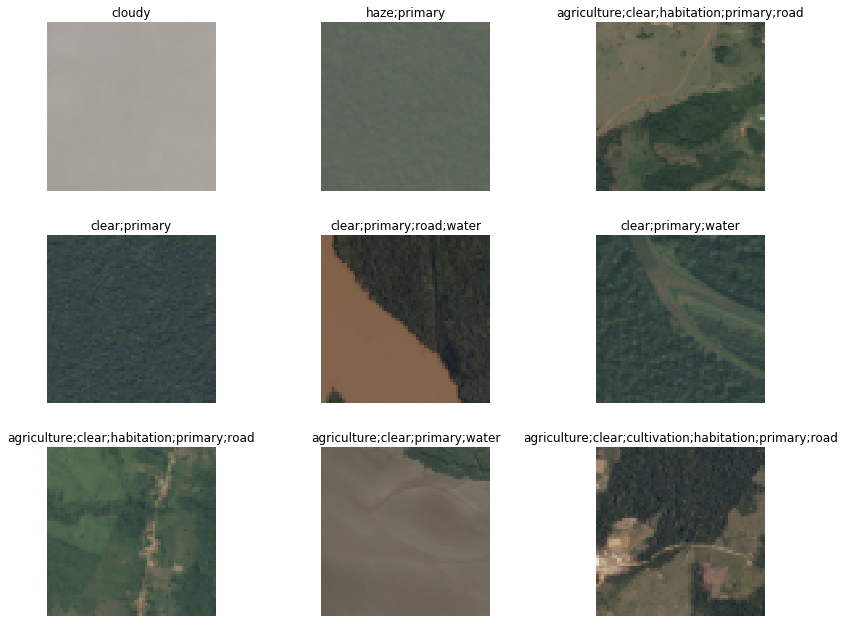

In [11]:
data.show_batch(rows=3, figsize=(12, 9))

## II. Train small data

### 1: Make data

### 2: Make model

In [8]:
arch = models.resnet50
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = create_cnn(data, arch, metrics=[acc_02, f_score])

/home/minhnc-lab/PROGRAMS/anaconda3/envs/fastaiv1/lib/python3.6/site-packages/fastai/vision/learner.py:105: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


### 3: Slight training

#### 3.a: find fair learning rate

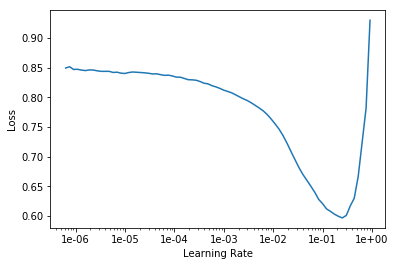

In [18]:
learn.lr_find()
learn.recorder.plot()

#### 3.b: train big learning rate then save weights

In [19]:
lr = 1e-2
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.124709,0.110730,0.939367,0.902545,02:49
1,0.111899,0.098882,0.954089,0.912297,02:44
2,0.101678,0.092748,0.954656,0.921274,02:33
3,0.097473,0.087870,0.957417,0.925264,02:36
4,0.092305,0.086309,0.955913,0.925517,02:36


In [20]:
learn.save('stage-1-rn50')

### 4: Finetune training

#### 4.a: unfreeze learner then find learning rate

In [23]:
learn.load('stage-1-rn50')
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


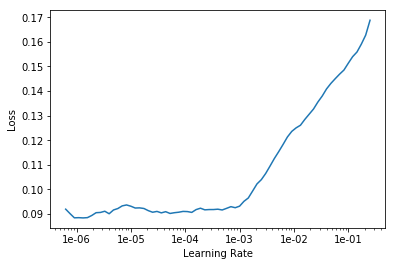

In [24]:
learn.lr_find()
learn.recorder.plot()

#### 4.b: train small learning rate then save weights

In [25]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.096867,0.091463,0.954176,0.921534,02:48
1,0.095828,0.089313,0.957773,0.923376,02:05
2,0.091358,0.085851,0.955775,0.924475,01:47
3,0.081823,0.084374,0.958304,0.925852,01:46
4,0.080518,0.082347,0.958987,0.929042,01:46


In [26]:
learn.save('stage-2-rn50')

## III. Train big data

### 1: Make data

In [9]:
data = (src.transform(tfms, size=128)
       .databunch().normalize(imagenet_stats))

### 2: Make model

In [10]:
learn.data = data

### 3: Slight training

#### 3.a: find fair learning rate

In [11]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


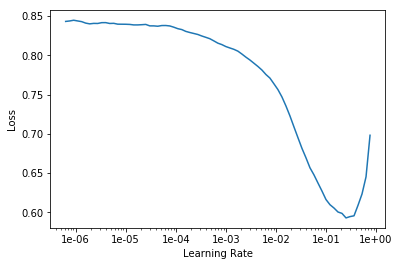

In [12]:
learn.lr_find()
learn.recorder.plot()

#### 3.b: train big learning rate then save weights

In [13]:
lr = 1e-2/2
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.127707,0.112381,0.943538,0.899206,02:27
1,0.110602,0.098989,0.949853,0.913318,01:22
2,0.104472,0.093849,0.951429,0.917158,01:23
3,0.096977,0.089646,0.952985,0.922433,01:23
4,0.095917,0.089308,0.955375,0.922804,01:23


In [14]:
learn.save('stage-1-256-rn50')

### 4: Finetune training

#### 4.a: unfreeze learner

In [15]:
learn.load(name='stage-1-256-rn50')
learn.unfreeze()

#### 4.b: train small learning rate then save weights

In [16]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.097544,0.089565,0.953966,0.920979,01:47
1,0.096946,0.089367,0.958101,0.923233,01:48
2,0.090783,0.086674,0.957214,0.924388,01:48
3,0.083021,0.083092,0.958413,0.928727,01:47
4,0.081687,0.082909,0.958616,0.928811,01:46


In [17]:
learn.save('stage-2-256-rn50')

In [18]:
learn.export()